In [1]:
import sys, os, glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from scipy.signal import find_peaks
from scipy.interpolate import UnivariateSpline, interp1d
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
from statsmodels.stats.libqsturng import psturng
import random

# logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)
logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.INFO)

%matplotlib inline
font = {'family' : 'Arial',
        'size'   : 7}
matplotlib.rc('font', **font)
plt.rcParams['svg.fonttype'] = 'none'
# plt.rcParams['pdf.fonttype'] = 42

# make a folder to store figures if not already there
!mkdir ../jupyter_figures


mkdir: ../jupyter_figures: File exists


In [2]:
#-------------------
# Facility functions
#-------------------

def splinePath(x, y, N, z=None):
    """Takes a set of (x,y) coordinates, spline along z if provided,
    otherwise along its path. Finally, interpolate at N equal
    distance points.  Return 2 or 3 size N numpy arrays representing
    interpolated N (x,y) or (x,y,z) coordinates.
    """
    if z is None:
        dr = (np.diff(x)**2 + np.diff(y)**2)**.5 # segment lengths
        r = np.zeros_like(x)
        r[1:] = np.cumsum(dr) # integrate path
        r_int = np.linspace(0, r.max(), N) # regular spaced path
        z, z_int = r, r_int
        splx = UnivariateSpline(z, x, s=0, ext='const') # interpolate
        # splx.set_smoothing_factor(0.5)
        x_int = splx(z_int)
        sply = UnivariateSpline(z, y, s=0, ext='const')
        # sply.set_smoothing_factor(0.5)
        y_int = sply(z_int)
        return x_int, y_int
    if z is not None:
        # check whether z is increasing -- requied for spline interpolate
        dz = np.diff(z)
        if not np.all(dz >= 0):
            exit('z for splinePath is not increasing!')
        z_int = np.linspace(z.min(), z.max(), N)
        splx = UnivariateSpline(z, x, s=0, ext='const') # interpolate
        # splx.set_smoothing_factor(0.5)
        x_int = splx(z_int)
        sply = UnivariateSpline(z, y, s=0, ext='const')
        # sply.set_smoothing_factor(0.5)
        y_int = sply(z_int)
        return x_int, y_int, z_int

def discretizePath(x, y, N, z=None):
    """Similar to splinePath, but do linear interpolation instead of spline.
    Takes a set of (x,y) coordinates, interpolate N points along z if provided,
    otherwise along its path. Return 2 or 3 size N numpy arrays representing
    interpolated N (x,y) or (x,y,z) coordinates.
    """
    if z is None:
        dr = (np.diff(x)**2 + np.diff(y)**2)**.5 # segment lengths
        r = np.zeros_like(x)
        r[1:] = np.cumsum(dr) # integrate path
        r_int = np.linspace(0, r.max(), N) # regular spaced path
        x_int = np.interp(r_int, r, x) # interpolate
        y_int = np.interp(r_int, r, y)
        return x_int, y_int
    if z is not None:
        z_int = np.linspace(z.min(), z.max(), N)
        x_int = np.interp(z_int, z, x) # interpolate
        y_int = np.interp(z_int, z, y)
        return x_int, y_int, z_int

def interpPolylineT(inputFolder, N=100):
    """Takes a list of .txt files storing ordered coordinates of polylines
    at relatively sparse time intervals, interpolate to generate
    a time series of polylines (N points along each polyline).

    The input files are a series of txt files that each contains a list
    of ordered x,y coordinates.  The file name of each txt file indicates
    the time frame.

    First, it reads in the series of x,y coordinates, interpolate equal
    distance points along the spline fitted line for plotting on the
    corresponding z plane and time point.

    Second, it interpolate along the time line to make sure every time point
    has a polyline representing the outline of the bud surface.

    Finally, all data will be saved into a pandas DataFrame, which is returned.
    """
    fileList = glob.glob(inputFolder+'*.txt')
    fileList.sort()

    xyData, tData = [], []
    for f in fileList:
        xyData.append(pd.read_csv(f, header = None, sep='\t'))
        f = f.split('/')[-1]
        f = f.split('.')[0]
        tData.append([int(s) for s in f.split('-') if s.isdigit()])
    tData = np.array(tData)
    # print(xyData)
    # print(tzData)

    # interpolate along each path to position crosslines
    pathData = []
    for i in range(len(xyData)):
        temp = xyData[i].values
        x, y = temp[:,0], temp[:,1]
        try:
            x_int, y_int = splinePath(x, y, N)
        except: # exception will rise when there are only 2 or 3 points
            x_int, y_int = discretizePath(x, y, N)
        # The following is time series in frame number
        tempT = np.ones_like(x_int) * tData[i]
        # Record the point position along path
        pathPos = np.arange(N)
        transposedList = list(map(list, zip(*[x_int, y_int, tempT, pathPos])))
        tempDF = pd.DataFrame(transposedList, columns = ['x', 'y', 't', 'pathPos'])
        pathData.append(tempDF)
    # concat all data into one big pandas data frame
    pathDF = pd.concat(pathData, ignore_index=True)
    pathDF.columns = ['x', 'y', 't', 'pathPos']

    # interpolate the mesh data for every time frame
    tData = []
    for i in pathDF.pathPos.unique():
        temp = pathDF.loc[pathDF.pathPos == i]
        temp = temp.sort_values('t', ascending=True)
        x, y, t = temp.x, temp.y, temp.t
        tN = int(t.max() - t.min() + 1)
        try:
            x_int, y_int, t_int = splinePath(x, y, tN, t)
        except:
            x_int, y_int, t_int = discretizePath(x, y, tN, t)
        tempPos = np.ones_like(x_int) * i
        transposedList = list(map(list, zip(*[x_int, y_int, t_int, tempPos])))
        tempDF = pd.DataFrame(transposedList, columns = ['x', 'y', 't', 'pathPos'])
        tData.append(tempDF)
    tDF = pd.concat(tData, ignore_index=True)
    tDF.columns = ['x', 'y', 't', 'pathPos']
    return tDF

def getPathLength(x, y):
    '''Calculate the cumulative length along the polyline defined by
    a series coordinates (x, y)
    
    Parameters:
        x, y: two ordered lists storing (x, y) coordinates along the polyline
    
    Returns:
        The cumulative length along the polyline
    '''
    dr = (np.diff(x)**2 + np.diff(y)**2)**.5 # segment lengths
    return np.sum(dr)

def getPathLengthSeries(df):
    '''Calculate the cumulative length of each (x,y) series across a time series
    
    Parameters:
        Pandas data frame object with columns "x", "y" and "t" that specifies
        (x, y) coordinates along a polyline path at different time points

    Returns:
        A list of cumulative length along a polyline at each time point
    '''
    pathLengthList = []
    for i in df.t.unique():
        temp = df.loc[df.t == i]
        pathLengthList.append(getPathLength(temp.x, temp.y))
    return pathLengthList

def savePathSeries(df, outputFolder):
    '''Save interpolated time series of (x,y) coordinates, each time point into
    one txt file in the outputFolder
    
    Parameters:
        Pandas data frame object with columns "x", "y" and "t" that specifies
        (x, y) coordinates along a polyline path at different time points

    Returns:
        A list of status stating whether a file was successfully saved for the time series
    '''
    statusList = []
    for i in df.t.unique():
        temp = df.loc[df.t == i]
        temp = temp[['x','y']]
        outputFilename = outputFolder + 't-' + f'{int(i):04}' + '.txt'
        temp.to_csv(outputFilename, sep='\t', index=False, header=False)
        statusList.append(os.path.isfile(outputFilename))
    return statusList

def getMinDistIndex(x0, y0, x, y):
    '''Calculate the distance between a reference pont (x0, y0) and
    points along a polyline (x, y).
        Returns the index of the minimum distance.
    
    Parameters:
        x0, y0: singular value of numbers representing coordinates of the reference point
        x, y: list of values representing a list of points along a polyline
    Returns:
        The index where the minimum of distance to reference point was found
    '''
    dist = []
    for i in range(len(x)):
        tempDist = ((x0-x[i])**2 + (y0-y[i])**2)**.5# distance to current point
        dist.append(tempDist)
    return np.argmin(dist)

def centerVector(x):
    """Center a vector by the middle point of two extreme value

    Parameter:
        1-d numpy array, or list, or pandas Series
    
    Returns:
        the same data type and shape as input, shifted by the middle point
    """
    midX = np.mean([np.min(x), np.max(x)])
    return x-midX

def clipLinescanProfiles(profileFolder, pathFolder, outputFolder, t_N_selected=None):
    '''Clip line profiles at each time point according to the beginning 
    and the end of the original path coordinates
    
    Parameters:
        profileFolder: contains txt files storing newXY coordinates, as well as
                        GFP and RFP intensity values along the path specified by
                        the newXY coordinates
        pathFolder: contains txt files storing the original user-drawn and
                    time-interpolated xy coordinates
        outputFolder: the location to store clipped line scan files
    
    Returns:
        A list of dataframes, each storing the clipped line scan data of one time point
        Meanwhile, each data frame will be saved as a txt file in the output folder
    '''
    pathList = glob.glob(pathFolder+'*.txt')
    pathList.sort()
    newPathList = glob.glob(profileFolder+'newXY*.txt')
    newPathList.sort()
    profileList1 = glob.glob(profileFolder+'GFP*.txt')
    profileList1.sort()
    profileList2 = glob.glob(profileFolder+'RFP*.txt')
    profileList2.sort()
    
    if t_N_selected == 0 or t_N_selected is None:
        t_N_selected = len(pathList)
    
    dfList = []
    FLIP_TOKEN = 0
    CLOCKWISE_T0 = 0
#     for i in range(1):# for testing
    for i in range(min([t_N_selected, len(pathList)])):
        f1, f2, f3, f4 = pathList[i], newPathList[i], profileList1[i], profileList2[i]
#         print(f1, f2, f3, f4)
        
        # Read in the 4 txt files storing (in order):
        # original path, new path, GFP profile and RFP profile
        df1 = pd.read_csv(f1, sep="\t", header = None)
        df1.columns = ["x", "y"]
        x0, y0 = df1.x.values[0], df1.y.values[0]# starting point of the original path
        x1, y1 = df1.x.values[-1], df1.y.values[-1]# ending point of the original path
        
        df2 = pd.read_csv(f2, sep="\t", header = None)
        df2.columns = ["x", "y"]
        x, y = np.array(df2.x), np.array(df2.y)# list of points of new path
        
        df3 = pd.read_csv(f3, sep="\t", header = 0, index_col = 0)
        df3.columns = ["GFP"]
        GFP = np.array(df3.GFP)# GFP profile (intensity values along new path)
        
        df4 = pd.read_csv(f4, sep="\t", header = 0, index_col = 0)
        df4.columns = ["RFP"]
        RFP = np.array(df4.RFP)# RFP profile (intensity values along new path)
        
        # Determine whether new path is in opposite direction of the original path on the first
        # time point, when the shape is relatively simple.
        # Use this token to determine wehther to flip the new path coordinates
        if i == 0:
            FLIP_TOKEN = isClockwise(df1.x, df1.y)*isClockwise(df2.x, df2.y)
            CLOCKWISE_T0 = isClockwise(df2.x, df2.y)

        assert FLIP_TOKEN in [1, -1]
        assert CLOCKWISE_T0 in [1, -1]
        if FLIP_TOKEN == -1:
#             print("Current file id: " + str(i) + ", flipped")
            x, y, GFP, RFP = map(np.flip, [x, y, GFP, RFP])
#         else:
#             print("Current file id: " + str(i) + ", NOT flipped")
                
        idx0 = getMinDistIndex(x0, y0, x, y)
#         roll_N = idx0 * isClockwise(x, y)
        roll_N = idx0 * CLOCKWISE_T0 * (-1)
        x, y, GFP, RFP = map(lambda xx: np.roll(xx, roll_N), [x, y, GFP, RFP])
        idx1 = getMinDistIndex(x1, y1, x, y)
        x, y, GFP, RFP = map(lambda xx: xx[:idx1], [x, y, GFP, RFP])
        
        transposedList = list(map(list, zip(*[x, y, GFP, RFP])))
        tempDF = pd.DataFrame(transposedList, columns = ['x', 'y', 'GFP', 'RFP'])
        outputFilename = outputFolder + "clipped-linescan-profile-t-" + f'{int(i):04}' + '.txt'

        tempDF.to_csv(outputFilename, sep='\t')
            
        dfList.append(tempDF)
    
    return dfList

def get_peak_counts(df, height=20.0, width=1.0):
    peakCounts = []
    for i in range(len(df.columns)):
        arr = df[df.columns[i]]
        peaks = find_peaks(arr, height=height, width=width)
    #     peaks = find_peaks(arr, height=np.nanmedian(arr), width=1)
        peakCounts.append(len(peaks[0]))
        # print(peaks[0])

    return peakCounts


In [3]:
# ***Curvature calculation functions***
def curvature_splines(x, y, spline_degree=3):
    """Calculate the signed curvature of a 2D curve at each point
    using interpolating splines.
    
    Parameters
    ----------
        x,y: numpy.array(dtype=float) shape (n_points, )
    
    Returns
    -------
        curvature: numpy.array shape (n_points, )
    """
    t = np.arange(x.shape[0])
#     std = error * np.ones_like(x)

    fx = UnivariateSpline(t, x, k=spline_degree)
    fy = UnivariateSpline(t, y, k=spline_degree)

    dx = fx.derivative(1)(t)
    d2x = fx.derivative(2)(t)
    dy = fy.derivative(1)(t)
    d2y = fy.derivative(2)(t)
    curvature = (dy*d2x - dx*d2y) / np.power(dx**2 + dy**2, 1.5)
    return curvature

def isClockwise(x, y, ratio_of_total_path=0.1):
    """Determines whether the direction following the first specied ratio
    of (x,y) points turns clockwise or not using cross product
        ***Note: only works for simple cases***
    
    Parameter:
        x, y: Two 1-d vectors representing x and y coordinates of points
        ratio_of_total_path: the ratio of total path length to determine the turning direction
    
    Returns:
        1 or -1 specifying whether it turns clockwise or not
    """
    x, y = centerVector(x), centerVector(y)
    selected_index = int( len(x)*ratio_of_total_path )
    x1, y1 = x[0], y[0]
    x2, y2 = x[selected_index], y[selected_index]
    v1 = [x1, y1]
    v2 = [x2, y2]
    if np.cross(v1, v2)<0:
        return 1;
    else:
        return -1;

def get_df_for_curvature(dfList):
    """The parameter dfList is exactly the format of the output from function clipLinescanProfiles.
    columns = ['x', 'y', 'GFP', 'RFP']
    The order of df in the list follows the time series.

    """
    
    for i in range(len(dfList)):
        tempDF = dfList[i]
        tempT = np.ones_like(tempDF.x) * i
#         tempDF.loc[ : , 'x']
        tempDF['t'] = pd.Series(tempT)
        dfList[i] = tempDF
    
    # concat all data into one big pandas data frame
    DF = pd.concat(dfList, ignore_index=True)
    DF.columns = ['x', 'y', 'GFP', 'RFP', 't']

    return DF

def get_curvature_df_xy(df):
    '''Calculate curvature along (x,y) for a single time point

    Input Parameters
    ----------------
        df: a pandas data frame with columns 'x' and 'y' (could have others) that specifies
    a series of (x,y) coordinates of a curve
    
    Returns:
    --------
        curvature_df: a pandas data frame adding a column 'curvature' storing the local
    curvature at each (x,y) coordinate
    '''
    assert 'x' in df.columns
    assert 'y' in df.columns
    
    # center the coordinates of x and y to align plots
    df.x, df.y = centerVector(df.x), centerVector(df.y)
    
    # calculate the curvature and store in a new column
    # The *1000 is to convert micron to mm scale
    df["curvature"] = curvature_splines(df.x, df.y) * 1000
    
    # reverse the sign of curvature if the curve is not turning clockwise
    if isClockwise(df.x, df.y) == -1:
        df["curvature"] = -1 * df["curvature"]
    
    return df

def get_curvature_df(df):
    ''' 
    This function calculate pixel-wise local curvature of a time series of curves
    specified by a series of (x, y) coordinates along the curve.
    
    Parameters
    ----------
        df: pandas dataframe containing 3 columns ('x', 'y', 't'; could have others)
            that represent (x, y) coordinates along a curve in a time seris denoted by 't'

        pixel_size: unit um/pixel, the pixel calibration for converting micron-unit (x,y)
                    coordinates to pixels
    
    Returns
    -------
        curvature_df: pandas dataframe storing pixel-wise curvature along the time series
                        of the curve. Curvature unit is mm^(-1)
    '''
    t_seris = df.t.unique()

    curvature_list = []
    clockwise = 0
    for t in t_seris:
        df_temp = df[df.t==t]
        # center the coordinates of x and y to align plots
        # reverse the sign of y coordinates because on the image y goes downwards
        # opposite to the reference frame of curvature calculation
        curve_x = centerVector(df_temp.x.values)
        curve_y = centerVector( -1 * df_temp.y.values)
        
        curvature_temp = curvature_splines(curve_x, curve_y, spline_degree=3) * 1000
        
        # flip the sign of curvature if the curve is not turning clockwise
        if t == t_seris[0]:
            clockwise = isClockwise(curve_x, curve_y)
        assert clockwise in [1, -1]
        if clockwise == -1:
            curvature_temp = -1 * curvature_temp
        curvature_list.append(pd.Series(curvature_temp))
    
    # Use the dfList data to construct simple-structured data frame for heatmap plotting
    df_cols = ["t-" + f'{int(t):04}' for t in t_seris]
    curvature_df = pd.DataFrame(dict(zip(df_cols, curvature_list)))

    return curvature_df


In [4]:
#-------------------
# Plotting functions
#-------------------

def plot_curve_series(df, outputFigPath, fig_width=1.2, fig_height=1.2, colorMap='jet'):
    '''The pandas data frame df should have columns "x", "y" and "t" representing (x, y) coordinates
    along a curve at a series of time points
    '''
    fig = plt.figure(figsize=(fig_width, fig_height), dpi=300)
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    
    sns.lineplot(x=df.x, y=df.y, hue=df.t,
                 sort=False, estimator=None, alpha=.1, size=.01, legend=False, palette=colorMap)

    # Flip the y-axis to match the image coordinates
    plt.gca().invert_yaxis()
    # Make the x and y axes equal in dimension to mimic image display
    plt.axis('equal')

    for o in fig.findobj():
        o.set_clip_on(False)
    for o in ax.findobj():
        o.set_clip_on(False)

    plt.savefig(outputFigPath)
    
    return ax

def plot_line_profile_heatmap(df, outputFigPath, fig_width=1.2, fig_height=1.0, axis_on_off='off', colorMap='Greys', show_cbar=True, transpose=True):
    '''The pandas data frame df should have intensity values in each column for each time point for plotting
    '''
    # make sure the axis_on_off argument is valid
    assert axis_on_off in ['on', 'off']

    plt.rcParams['svg.fonttype'] = 'none'
    plt.rcParams['font.size'] = 7
    plt.rcParams['font.sans-serif'] = 'Arial'

    fig = plt.figure(figsize=(fig_width, fig_height), dpi=300)
    
    if axis_on_off == 'on':
        ax = fig.add_axes([0.3, 0.3, 0.6, 0.6])
    else:
        ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    
    if transpose:
        ax = sns.heatmap(df.transpose(), cmap=colorMap, vmax=255, cbar=show_cbar)
    else:
        ax = sns.heatmap(df, cmap=colorMap, vmax=255, cbar=show_cbar)

    for o in fig.findobj():
        o.set_clip_on(False)
    for o in ax.findobj():
        o.set_clip_on(False)
    
    plt.axis(axis_on_off)

    plt.savefig(outputFigPath)
    
    return ax

def plot_curvature_heatmap(curvature_df, outputFigPath, colorMax=100, fig_width=1.2, fig_height=1.0, show_cbar=True):
    '''plot heatmap of curvature, save .svg as outputFigPath'''
    
    fig = plt.figure(figsize=(fig_width, fig_height), dpi=300)
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    sns.heatmap(curvature_df.transpose(), cmap='coolwarm', vmin=-1*colorMax, vmax=colorMax, cbar=show_cbar)

    for o in fig.findobj():
        o.set_clip_on(False)
    for o in ax.findobj():
        o.set_clip_on(False)

    plt.axis("off")
    
    plt.savefig(outputFigPath)

    return ax

def plot_curvature(df, outputFigPath=None, size=3, colorNormMax=80,
                   x_max=None, y_max=None):
    
    assert 'x' in df.columns
    assert 'y' in df.columns
    
    fig = plt.figure(figsize=(1.2,1.2), dpi=300)
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    
    plt.scatter(df.x, df.y, s=size, c=df.curvature, vmin=-1*colorNormMax, vmax=colorNormMax, cmap="coolwarm")

    # When supplied, specify the range of x, y axes
    if x_max is not None:
        plt.xlim([0, x_max])
    if y_max is not None:
        plt.ylim([0, y_max])
    
    # Flip the y-axis to match the image coordinates
    plt.gca().invert_yaxis()
    
    # Make the x and y axes equal in dimension to mimic image display
    plt.axis('equal')
    plt.axis("off")
    
    for o in fig.findobj():
        o.set_clip_on(False)
    for o in ax.findobj():
        o.set_clip_on(False)
    
    if outputFigPath is not None:
        plt.savefig(outputFigPath)
    
    return ax

def plot_boundary(df, outputFigPath=None,
                  line_width=0.8, line_color='k',
                  x_max=None, y_max=None):
    
    assert 'x' in df.columns
    assert 'y' in df.columns
    
    fig = plt.figure(figsize=(1.2,1.2), dpi=300)
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    
    plt.plot(df.x, df.y, lw=line_width, color=line_color)
    
    # When supplied, specify the range of x, y axes
    if x_max is not None:
        plt.xlim([0, x_max])
    if y_max is not None:
        plt.ylim([0, y_max])
    
    # Flip the y-axis to match the image coordinates
    plt.gca().invert_yaxis()

    # Make the x and y axes equal in dimension to mimic image display
    plt.axis('equal')
    plt.axis("off")
    
    for o in fig.findobj():
        o.set_clip_on(False)
    for o in ax.findobj():
        o.set_clip_on(False)
    
    if outputFigPath is not None:
        plt.savefig(outputFigPath)
    
    return ax

def plot_perimeter_and_nuclei_number(pathLengths, peakCounts, outputFigPath, xTickInterval=5.0, fig_width=1.2, fig_height=1.0):
    '''
    '''

    # -------------------------
    # Fitting pathLengths array
    # -------------------------
    
    x1 = np.arange(len(pathLengths)) / 12.0
    x_max = x1[-1]
    y1 = np.array(pathLengths)/np.nanpercentile(pathLengths,90)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x1, y1)

    print("\npathLengths linear regression parameters (slope, intercep, r square, p_value and std_err):")
    print(slope, intercept, r_value**2, p_value, std_err)

    last1 = slope*x_max + intercept
    first1 = slope*0 + intercept
    print("\nThe fitted path length value at the last time point (should be close to 1):")
    print(last1)
    print("\nThe ratio of fitted path length value of the last time point over the first time point:")
    print(last1/first1)

    # -------------------------    
    # Fitting peakCounts array
    # -------------------------
    
    x2 = np.arange(len(peakCounts)) / 12.0
    y2 = np.array(peakCounts)/np.nanpercentile(peakCounts,90)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x2, y2)
    
    print("\npeakCounts linear regression parameters (slope, intercep, r square, p_value and std_err):")
    print(slope, intercept, r_value**2, p_value, std_err)
    
    last2 = slope*x_max + intercept
    first2 = slope*0 + intercept
    print("\nThe fitted path length value at the last time point (should be close to 1):")
    print(last2)
    print("\nThe ratio of fitted path length value of the last time point over the first time point:")
    print(last2/first2)

    # --------
    # Plotting
    # --------
    
    fig = plt.figure(figsize=(fig_width, fig_height), dpi=300)
    ax = fig.add_axes([0.3, 0.2, 0.6, 0.7])

    plt.plot(x2, y2, "g", lw=.8)
    plt.plot([0, x_max], [first2, last2], "g--", lw=.8)
    plt.plot(x1, y1, "k", lw=.8)
    plt.plot([0, x_max], [first1, last1], "k--", lw=.8)

    for o in fig.findobj():
        o.set_clip_on(False)
    for o in ax.findobj():
        o.set_clip_on(False)

    # customize the x ticks to correspond to something meaningful
    # since the time frame is 5 min intervals, a reasonable number here
    # could be 60 frames = 5 hours
    xTicks = np.arange(0, x_max + 1.0/12.0, xTickInterval)
    plt.xticks(xTicks)
    plt.yticks([0.6, 0.8, 1.0])

    plt.xlabel("Time (h)")
    plt.ylabel("Bud perimeter or\nnuclear count")

    plt.savefig(outputFigPath)
    
    return ax

def test_peak_finding_parameters(df, outputFigPath=None, t=0, height=20.0, width=1.0, fig_width=4.0, fig_height=1.2):
    '''Plot out the intensity values and found peaks using
    specified peak finding parameters
    
    The pandas data frame df should have intensity values along a curve
    in each column for each time point
    '''
    arr = df[df.columns[t]]
    peaks = find_peaks(arr, height=height, width=width)

    peakValues = [arr[i] for i in peaks[0]]
    print(peakValues)
    
    fig = plt.figure(figsize=(fig_width, fig_height), dpi=300)
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    
    plt.plot(arr, "gray")
    plt.plot(peaks[0], peakValues, "ok")
    
    for o in fig.findobj():
        o.set_clip_on(False)
    for o in ax.findobj():
        o.set_clip_on(False)

    if outputFigPath is not None:
        plt.savefig(outputFigPath)
    
    return ax


In [5]:
# Information of all data sets

parentFolderList = ['../data/dynamic-line-scan-analysis/190331-4_K14Rhet-HisG-dataset/',
                    '../data/dynamic-line-scan-analysis/180218-mTmGHisG-ROI1-dataset/',
                    '../data/dynamic-line-scan-analysis/190227-mTmGHisG-ROI1-dataset/',
                    '../data/dynamic-line-scan-analysis/190227-mTmGHisG-ROI2-dataset/',
                    '../data/dynamic-line-scan-analysis/200125-K14R-HisG-ROI1-dataset/',
                    '../data/dynamic-line-scan-analysis/190331-1_K14Rhomo-HisG-dataset/',
                    '../data/dynamic-line-scan-analysis/190331-6_K14Rhet-HisG-dataset/',
                    '../data/dynamic-line-scan-analysis/180624-mTmGHisG-SMG1-ROI1-dataset-low-quality/',
                    '../data/dynamic-line-scan-analysis/180325-mTmGHisG-ROI1-dataset/',
                    '../data/dynamic-line-scan-analysis/180325-mTmGHisG-ROI2-dataset/',
                    '../data/dynamic-line-scan-analysis/180624-mTmGHisG-SMG1-ROI2-dataset/',
                    '../data/dynamic-line-scan-analysis/180624-mTmGHisG-SMG2-ROI1-dataset/',
                    '../data/dynamic-line-scan-analysis/180624-mTmGHisG-SMG2-ROI2-dataset/']

datasetPrefixList = ['190331-4_K14Rhet-HisG-1-1-denoised-BCratio-img-seq-stacked-z-26',
                      '180218-mTmGHisG-ROI1-denoised-BCratio-img-seq-BC-all-z-24',
                      '190227-mTmGHisG-2photon-E13-ROI1-denoised-BC-all-mid-plane',
                      '190227-mTmGHisG-2photon-E13-ROI2-denoised-BC-all-mid-plane',
                      '2020-01-25-K14R-HisG-2photon-25x-2-denoised-ROI1-z-25',
                      '190331-1_K14Rhomo-HisG-1-1-denoised-z-27',
                      '190331-6_K14Rhet-HisG-2-2-denoised-z-23',
                      '180624-2photon-mTmGHisG-SMG1-combined-BC-all-ROI1-z-24-denoised',
                      '180325-mTmGHisG-2photon-mosaic-ROI1-denoised-BC-all-z-24',
                      '180325-mTmGHisG-2photon-mosaic-ROI2-denoised-BC-all-z-30',
                      '180624-2photon-mTmGHisG-SMG1-combined-BC-all-ROI2-z-40-denoised',
                      '180624-2photon-mTmGHisG-SMG2-combined-BC-all-ROI1-z-31-denoised',
                      '180624-2photon-mTmGHisG-SMG2-combined-BC-all-ROI2-z-36-denoised']

# In the cases when the time series goes beyond cleft progression into cleft widening,
# select the number of time points preceding the widening
t_N_selected_list = np.zeros_like(range(len(datasetPrefixList)))
t_N_selected_list[2] = 150


In [6]:
# Master function to get all potentially useful plots for each dataset
def process_dataset(parentFolder, datasetPrefix):
    
    # -----------------------------------------------
    # Reading in the data and prepare for data frames
    # -----------------------------------------------

    inputFolder = parentFolder + datasetPrefix + '-linescan-output/'
    # N points per path will be interpolated
    df = interpPolylineT(inputFolder, N=100)

    outputFolder = inputFolder[:-1] + "-t-interpolated/"
    # Only need to run it once
    if not os.path.isdir(outputFolder):
        os.makedirs(outputFolder, exist_ok=True)
        status = savePathSeries(df, outputFolder)

    t_N_selected = t_N_selected_list[i]
    # Select the time points before cleft bottom widening
    if t_N_selected != 0:    
        t_min = np.min(df.t)
        df=df[ df.t < (t_min + t_N_selected) ]


    # Get the data frame list of line profile
    profileFolder = parentFolder + datasetPrefix + '-dynamic-line-scan-profile/'
    pathFolder = parentFolder + datasetPrefix + '-linescan-output-t-interpolated/'
    outputFolder = parentFolder + datasetPrefix + '-t-interpolated-clipped/'
    os.makedirs(outputFolder, exist_ok=True)
    dfList = clipLinescanProfiles(profileFolder, pathFolder, outputFolder, t_N_selected=t_N_selected)


    # Use the dfList data to construct simple-structured GFP and RFP intensity data frames for heatmap plotting
    df_cols = ["t-" + f'{int(i):04}' for i in range(len(dfList))]
    dfGFP = pd.DataFrame(dict(zip(df_cols, [df.GFP for df in dfList])))
    dfRFP = pd.DataFrame(dict(zip(df_cols, [df.RFP for df in dfList])))
    
    # Calculate the local curvature of bud surface outline
    df_for_curvature = get_df_for_curvature(dfList)
    curvature_df = get_curvature_df(df_for_curvature)

    # ---------
    # Plottings
    # ---------
    
    outputFigPath = "../jupyter_figures/" + datasetPrefix + "-mid-plane-outline.svg"
    plot_curve_series(df, outputFigPath, fig_width=1.2, fig_height=1.2)
    
    # plotting heamap showing the straightened time series of GFP and the curvature heatmap
    outputFigPath = "../jupyter_figures/" + datasetPrefix + "-dynamic-kymograph-GFP.png"
    plot_line_profile_heatmap(dfGFP, outputFigPath, show_cbar=False)
    
    outputFigPath = "../jupyter_figures/" + datasetPrefix + "-curvature-heatmap.png"
    plot_curvature_heatmap(curvature_df, outputFigPath, show_cbar=False)

    outputFigPath = "../jupyter_figures/" + datasetPrefix + "-dynamic-kymograph-GFP-axis-on.png"
    plot_line_profile_heatmap(dfGFP, outputFigPath, axis_on_off='on')
    
    # plotting heamap showing the straightened time series of RFP
    outputFigPath = "../jupyter_figures/" + datasetPrefix + "-dynamic-kymograph-RFP.png"
    plot_line_profile_heatmap(dfRFP, outputFigPath, show_cbar=False)

    test_peak_finding_parameters(dfGFP, t=0, height=20.0, width=1.0)
    
    # Caculate the path length at each time point of the series
    pathLengths = getPathLengthSeries(df)

    # Caculate the peak number using GFP intensity profile at each time point of the series
    peakCounts = get_peak_counts(dfGFP, height=20.0, width=1.0)

    outputFigPath = "../jupyter_figures/" + datasetPrefix + "-perimeter-and-nuclei-number-over-time.svg"
    plot_perimeter_and_nuclei_number(pathLengths, peakCounts, outputFigPath)    

    plt.close('all')


In [7]:
# Loop through all data sets to get potentially useful plots
for i in np.arange(0, len(parentFolderList)):
    parentFolder = parentFolderList[i]
    datasetPrefix = datasetPrefixList[i]
    process_dataset(parentFolder, datasetPrefix)


2020-04-16 15:14:32,699 - INFO - NumExpr defaulting to 8 threads.
[33.0, 35.0, 31.0, 31.0, 51.0, 55.0, 82.0, 80.0, 252.0, 216.0, 41.0, 41.0, 94.0, 240.0, 244.0, 250.0, 140.0, 132.0, 185.0, 207.0, 87.0, 83.0, 24.0, 123.0, 104.0, 135.0, 20.0, 25.0, 27.0, 108.0, 131.0, 22.0, 45.0, 31.0, 23.0, 31.0, 86.0, 255.0, 97.0, 96.0, 108.0, 131.0, 173.0, 119.0, 138.0, 131.0, 35.0, 49.0, 42.0, 31.0, 30.0, 49.0, 157.0, 128.0, 145.0, 220.0, 68.0, 237.0, 255.0, 30.0, 27.0, 52.0, 56.0, 28.0, 68.0, 56.0, 69.0, 41.0, 56.0, 39.0, 95.0, 62.0, 95.0, 95.0, 35.0, 35.0, 33.0, 58.0, 41.0, 41.0]

pathLengths linear regression parameters (slope, intercep, r square, p_value and std_err):
0.020252124558077234 0.6188838677908286 0.9900326366339096 3.3547110824161097e-253 0.0001282623281800719

The fitted path length value at the last time point (should be close to 1):
1.0441784835104504

The ratio of fitted path length value of the last time point over the first time point:
1.6871961572334335

peakCounts linear regres

In [16]:
# --------------------------------------------------------
# Reading in the data and prepare data frames for plotting
# --------------------------------------------------------

# # Specify the ith dataset from the above list, 0 indexed
i = 0
re_run = False # Specify whether to re-write the t-interpolated data
parentFolder = parentFolderList[i]
datasetPrefix = datasetPrefixList[i]

inputFolder = parentFolder + datasetPrefix + '-linescan-output/'
# N points per path will be interpolated
df = interpPolylineT(inputFolder, N=100)

outputFolder = inputFolder[:-1] + "-t-interpolated/"

# Only need to run it once
if not os.path.isdir(outputFolder):
    os.makedirs(outputFolder, exist_ok=True)
    status = savePathSeries(df, outputFolder)

if re_run == True:
    os.makedirs(outputFolder, exist_ok=True)
    status = savePathSeries(df, outputFolder)


t_N_selected = t_N_selected_list[i]
# Select the time points before cleft bottom widening
if t_N_selected != 0:    
    t_min = np.min(df.t)
    df=df[ df.t < (t_min + t_N_selected) ]


In [17]:
# Get the data frame list of line profile
profileFolder = parentFolder + datasetPrefix + '-dynamic-line-scan-profile/'
pathFolder = parentFolder + datasetPrefix + '-linescan-output-t-interpolated/'
outputFolder = parentFolder + datasetPrefix + '-t-interpolated-clipped/'
os.makedirs(outputFolder, exist_ok=True)
dfList = clipLinescanProfiles(profileFolder, pathFolder, outputFolder, t_N_selected=t_N_selected)


# Use the dfList data to construct simple-structured GFP and RFP intensity data frames for heatmap plotting
df_cols = ["t-" + f'{int(i):04}' for i in range(len(dfList))]
dfGFP = pd.DataFrame(dict(zip(df_cols, [df.GFP for df in dfList])))
dfRFP = pd.DataFrame(dict(zip(df_cols, [df.RFP for df in dfList])))

# Calculate the local curvature of bud surface outline
df_for_curvature = get_df_for_curvature(dfList)
curvature_df = get_curvature_df(df_for_curvature)


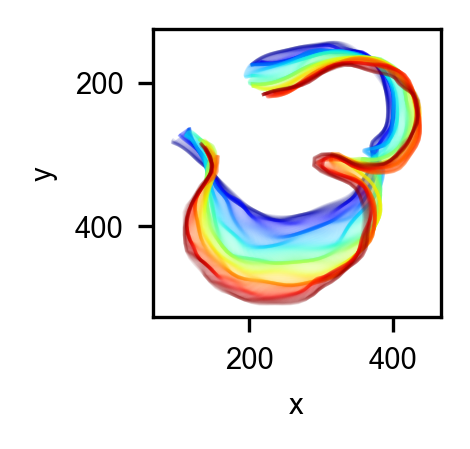

In [19]:
outputFigPath = "../jupyter_figures/" + datasetPrefix + "-mid-plane-outline.svg"
plot_curve_series(df, outputFigPath, fig_width=1.2, fig_height=1.2)


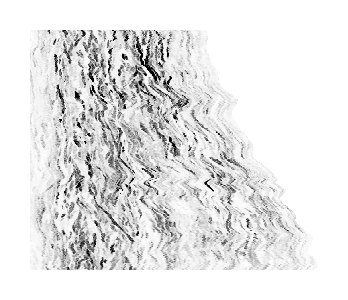

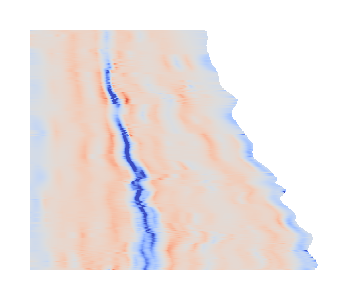

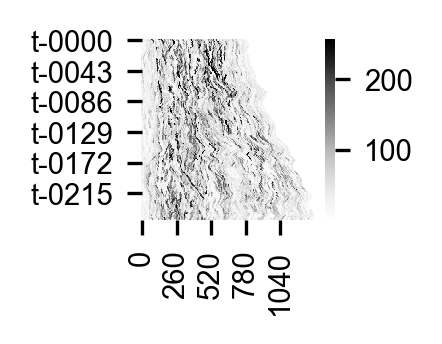

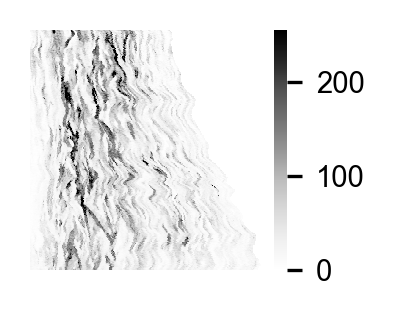

In [20]:
# plotting heamap showing the straightened time series of GFP

outputFigPath = "../jupyter_figures/" + datasetPrefix + "-dynamic-kymograph-GFP.png"
plot_line_profile_heatmap(dfGFP, outputFigPath, show_cbar=False)

outputFigPath = "../jupyter_figures/" + datasetPrefix + "-curvature-heatmap.png"
plot_curvature_heatmap(curvature_df, outputFigPath, show_cbar=False)

outputFigPath = "../jupyter_figures/" + datasetPrefix + "-dynamic-kymograph-GFP-axis-on.png"
plot_line_profile_heatmap(dfGFP, outputFigPath, axis_on_off='on')

# # plotting heamap showing the straightened time series of RFP
outputFigPath = "../jupyter_figures/" + datasetPrefix + "-dynamic-kymograph-RFP.png"
plot_line_profile_heatmap(dfRFP, outputFigPath)

# use svg backend to get the color bar

# outputFigPath = "./jupyter_figures/" + datasetPrefix + "-dynamic-kymograph-GFP.svg"
# plot_line_profile_heatmap(dfGFP, outputFigPath, show_cbar=True)

# outputFigPath = "./jupyter_figures/" + datasetPrefix + "-curvature-heatmap.svg"
# plot_curvature_heatmap(curvature_df, outputFigPath, show_cbar=True)

# outputFigPath = "./jupyter_figures/" + datasetPrefix + "-dynamic-kymograph-GFP-jet.svg"
# plot_line_profile_heatmap(dfGFP, outputFigPath, colorMap='jet', show_cbar=True)


[33.0, 35.0, 31.0, 31.0, 51.0, 55.0, 82.0, 80.0, 252.0, 216.0, 41.0, 41.0, 94.0, 240.0, 244.0, 250.0, 140.0, 132.0, 185.0, 207.0, 87.0, 83.0, 24.0, 123.0, 104.0, 135.0, 20.0, 25.0, 27.0, 108.0, 131.0, 22.0, 45.0, 31.0, 23.0, 31.0, 86.0, 255.0, 97.0, 96.0, 108.0, 131.0, 173.0, 119.0, 138.0, 131.0, 35.0, 49.0, 42.0, 31.0, 30.0, 49.0, 157.0, 128.0, 145.0, 220.0, 68.0, 237.0, 255.0, 30.0, 27.0, 52.0, 56.0, 28.0, 68.0, 56.0, 69.0, 41.0, 56.0, 39.0, 95.0, 62.0, 95.0, 95.0, 35.0, 35.0, 33.0, 58.0, 41.0, 41.0]


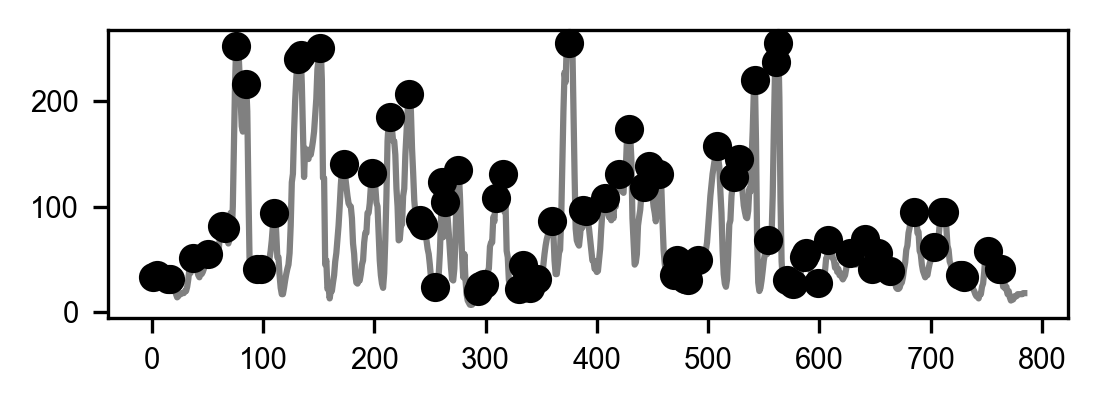

In [21]:
output_filename = '../jupyter_figures/' + datasetPrefix + '-GFP-peak-count.svg'
test_peak_finding_parameters(dfGFP, outputFigPath=output_filename, t=0, height=20.0, width=1.0)



pathLengths linear regression parameters (slope, intercep, r square, p_value and std_err):
0.020252124558077234 0.6188838677908286 0.9900326366339096 3.3547110824161097e-253 0.0001282623281800719

The fitted path length value at the last time point (should be close to 1):
1.0441784835104504

The ratio of fitted path length value of the last time point over the first time point:
1.6871961572334335

peakCounts linear regression parameters (slope, intercep, r square, p_value and std_err):
0.019054496312234402 0.6195409600770374 0.7785168371944622 3.9428437816658326e-84 0.0006415004507628858

The fitted path length value at the last time point (should be close to 1):
1.0196853826339598

The ratio of fitted path length value of the last time point over the first time point:
1.6458724254602408


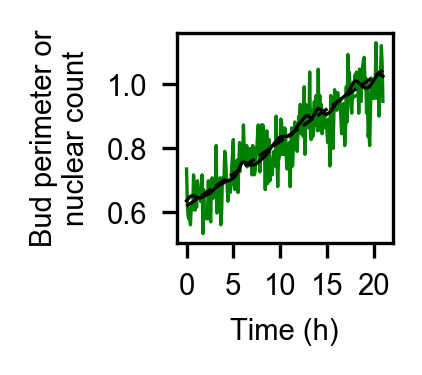

In [22]:
# Caculate the path length at each time point of the series
pathLengths = getPathLengthSeries(df)

# Caculate the peak number using GFP intensity profile at each time point of the series
peakCounts = get_peak_counts(dfGFP, height=20.0, width=1.0)

outputFigPath = "../jupyter_figures/" + datasetPrefix + "-perimeter-and-nuclei-number-over-time.svg"
plot_perimeter_and_nuclei_number(pathLengths, peakCounts, outputFigPath, fig_width=1.2, fig_height=1.0)


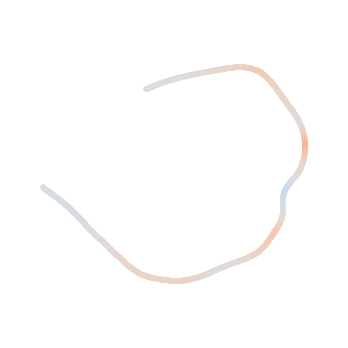

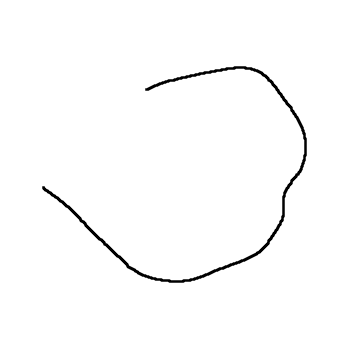

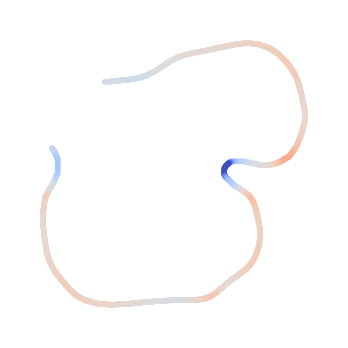

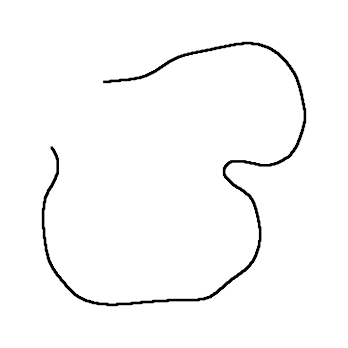

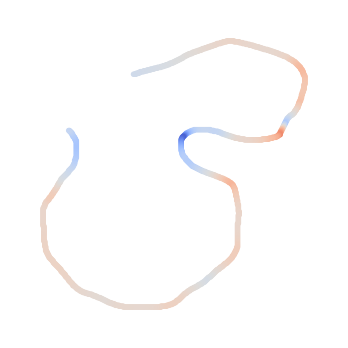

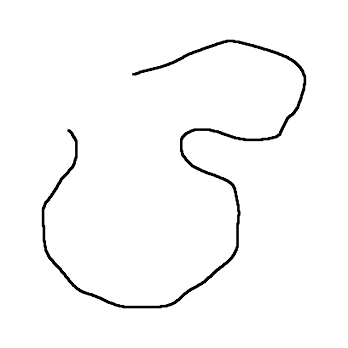

In [23]:
# Plot outlines for making showcase example to include in the supplemental figures
for t in [0, 143, 252]:
    curvature_df_temp = get_curvature_df_xy(dfList[t])
    
    figFileName = '../jupyter_figures/' + datasetPrefix + '-curvature-plot-t-' + str(t) + '.svg'
    plot_curvature(curvature_df_temp, outputFigPath=figFileName,
                   x_max=200, y_max=200,
                   size=0.1, colorNormMax=100)
    
    figFileName = '../jupyter_figures/' + datasetPrefix + '-boundary-t-' + str(t) + '.svg'
    plot_boundary(curvature_df_temp, outputFigPath=figFileName,
                   x_max=200, y_max=200,
                   line_width=0.6, line_color='k')
